In [1]:
import numpy as np
import sys
sys.path.append("../../")
import utility
import pandas as pd

from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

from scipy.stats import kruskal
from statsmodels.stats.proportion import proportions_chisquare

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib

import statsmodels.api as sm

from scipy import stats

import pandas as pd

import math


In [8]:
df_IEA_train = pd.read_csv("../../output/IEA_train.csv").set_index("sid")
df_IEA_test = pd.read_csv("../../output/IEA_test.csv").set_index("sid")

df_IEA_all = pd.concat( [df_IEA_train, df_IEA_test] )

In [14]:
df = utility.load_longitudinal()

df_used = pd.merge(df, df_IEA_all, left_index = True, right_index = True)

/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/ocean/projects/asc170022p/juc91/anaconda/lib/python3.8/site-packages/pandas/core/series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

# Regression with Both IEAs and covariates

In [27]:
independents = ["IEA0", "IEA1", 
       "Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']

dependents = ['FEV1pp_utah_P2', 'FEV1_FVC_utah_P2', 'SGRQ_scoreTotal_P2', "MMRCDyspneaScor_P2", 'distwalked_P2',
           'delta_FEV1pp_P2P3', "delta_FEV1FVC_P2P3",
           ]

models_IEA = []
cov_dict_IEA = {iii:[] for iii in cov}

In [28]:
for ccc in dependents:
    X = df_used[independents]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx].astype(float)
    
    X = sm.add_constant(X.apply(stats.zscore))
    y = stats.zscore(y)
    
    
    M_OLS = sm.OLS(y, X).fit()

    models_IEA.append(M_OLS)

    
    v = M_OLS.summary2().tables[1].values
    
    
    for iii in range(1, len(cov) + 1):
        col = cov[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_IEA[col].append(eee + "\n" + CI1)

# Base Regression with covariates only

In [29]:
independents = ["Age_P2", "gender", 'race', 'ATS_PackYears_P2', 'BMI_P2', "smoking_status_P2",
       'pctEmph_Thirona_P2', 'Perc15_Insp_Thirona_P2', 'pctGasTrap_Thirona_P2',
       'Pi10_Thirona_P2',  'WallAreaPct_seg_Thirona_P2']

dependents = ['FEV1pp_utah_P2', 'FEV1_FVC_utah_P2', 'SGRQ_scoreTotal_P2', "MMRCDyspneaScor_P2", 'distwalked_P2',
           'delta_FEV1pp_P2P3', "delta_FEV1FVC_P2P3",
           ]

models_base = []
cov_dict_base = {iii:[] for iii in cov}

In [30]:
for ccc in dependents:
    X = df_used[cov]
        
    y = df_used[ccc]
    idx = np.bitwise_and(~np.isnan(y), ~np.isnan(X).any(1))
    
    X = X[idx]
    y = y[idx].astype(float)
    
    X = sm.add_constant(X.apply(stats.zscore))
    y = stats.zscore(y)
    
    
    M_OLS = sm.OLS(y, X).fit()

    models_base.append(M_OLS)

    
    v = M_OLS.summary2().tables[1].values
    
    
    for iii in range(1, len(cov) + 1):
        col = cov[iii-1]
        eee = "{:.2f}".format(v[iii, 0])
        ppp = v[iii, 3]
        if ppp<.05:
            eee += "*"
        if ppp<.01:
            eee += "*"
        if ppp<.001:
            eee += "*"
            
        CI1 = "({:.2f}, {:.2f})".format(v[iii, 4], v[iii, 5])
        
        cov_dict_base[col].append(eee + "\n" + CI1)

# Computing p-values for likelihood ratio test

In [59]:


from scipy.stats.distributions import chi2


p_values = []

for iii in range(len(models_IEA)):
    model_null = models_base[iii]
    model_alt = models_IEA[iii]
    
    ll_null = model_null.llf
    ll_alt = model_alt.llf
    dg_null = model_null.df_model
    dg_alt = model_alt.df_model
    
    chi2_stat = -2 * (ll_null-ll_alt)
    p = chi2.sf(chi2_stat, dg_alt-dg_null)
    
    p_values.append( p )

p_values_str = []
for iii in p_values:
    if iii < .001:
        p_values_str.append("<.001")
    else:
        p_values_str.append("{:.3f}".format(iii))
    
p_values = np.array(p_values)[:, None]
p_values_str = np.array(p_values_str)[:, None]

# Table for p-values

In [67]:
rows = ["FEV$_1$ %predicted", "FEV$_1$ / FVC", "SGRQ Total Score", "MMRC Dyspnea Score", "6-Minute-Walk Distance", 
        "$\Delta$FEV$_1$ %predicted", "$\Delta$FEV$_1$/FVC"
       ]


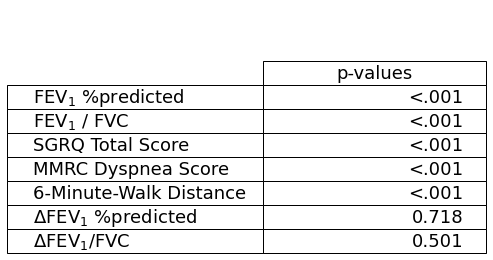

In [73]:
fig, ax = plt.subplots(figsize=(2,1))

the_table=plt.table(cellText = p_values_str, rowLabels = rows, 
                    colLabels = ["p-values"])

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

# Table for beta coeffcients

In [ ]:
betas = [ cov_dict_IEA['IEA0'], cov_dict_IEA['IEA1'] ]

In [75]:
cov_dict_IEA

{'IEA0': ['-0.00\n(-0.07, 0.07)',
  '-0.10**\n(-0.16, -0.04)',
  '0.21***\n(0.11, 0.31)',
  '0.16**\n(0.05, 0.26)',
  '0.03\n(-0.08, 0.13)',
  '-0.08\n(-0.27, 0.12)',
  '-0.09\n(-0.29, 0.11)'],
 'IEA1': ['-0.24***\n(-0.32, -0.16)',
  '-0.03\n(-0.10, 0.04)',
  '0.22***\n(0.10, 0.33)',
  '0.22***\n(0.10, 0.34)',
  '-0.43***\n(-0.55, -0.32)',
  '0.02\n(-0.23, 0.27)',
  '-0.03\n(-0.29, 0.23)'],
 'Age_P2': ['0.10***\n(0.06, 0.14)',
  '-0.05**\n(-0.09, -0.02)',
  '-0.10**\n(-0.16, -0.04)',
  '-0.02\n(-0.08, 0.04)',
  '-0.15***\n(-0.21, -0.09)',
  '0.21***\n(0.09, 0.33)',
  '0.11\n(-0.02, 0.23)'],
 'gender': ['-0.07**\n(-0.11, -0.03)',
  '-0.02\n(-0.05, 0.01)',
  '0.20***\n(0.14, 0.26)',
  '0.20***\n(0.13, 0.26)',
  '-0.24***\n(-0.30, -0.18)',
  '-0.04\n(-0.16, 0.08)',
  '-0.09\n(-0.21, 0.04)'],
 'race': ['0.05*\n(0.01, 0.08)',
  '0.04*\n(0.01, 0.07)',
  '0.12***\n(0.06, 0.17)',
  '0.15***\n(0.09, 0.20)',
  '-0.18***\n(-0.24, -0.13)',
  '-0.03\n(-0.15, 0.09)',
  '-0.04\n(-0.16, 0.08)'],
 'ATS

In [ ]:
fig, ax = plt.subplots(figsize=(16,12))

the_table=plt.table(cellText=p_values, rowLabels=cov_label, 
                    colLabels = ["IEA$_{emph}$", "IEA$_{airway}$"],
                     colWidths = [.1]*corr_coef.shape[1], loc='center', fontsize = 50, cellLoc = "center"
                   )

plt.axis('off')

the_table.auto_set_font_size(False)
the_table.set_fontsize(18)
the_table.scale(2, 2)

In [ ]:
plt.table()

In [39]:
res_IEA

,IEA0,IEA1,Age_P2,gender,race,ATS_PackYears_P2,BMI_P2,smoking_status_P2,pctEmph_Thirona_P2,Perc15_Insp_Thirona_P2,pctGasTrap_Thirona_P2,Pi10_Thirona_P2,WallAreaPct_seg_Thirona_P2
models,,,,,,,,,,,,,
IEA_FEV$_1$ %predicted,"-0.00\n(-0.07, 0.07)","-0.24***\n(-0.32, -0.16)","0.10***\n(0.06, 0.14)","-0.07**\n(-0.11, -0.03)","0.05*\n(0.01, 0.08)","-0.05**\n(-0.09, -0.02)","0.11***\n(0.05, 0.17)","0.01\n(-0.03, 0.05)","-0.21***\n(-0.29, -0.14)","-0.11*\n(-0.21, -0.02)","-0.53***\n(-0.62, -0.45)","-0.34***\n(-0.41, -0.27)","-0.02\n(-0.09, 0.05)"
IEA_FEV$_1$ / FVC,"-0.10**\n(-0.16, -0.04)","-0.03\n(-0.10, 0.04)","-0.05**\n(-0.09, -0.02)","-0.02\n(-0.05, 0.01)","0.04*\n(0.01, 0.07)","-0.06***\n(-0.09, -0.03)","0.05\n(-0.00, 0.10)","-0.07***\n(-0.10, -0.04)","-0.20***\n(-0.26, -0.14)","0.08*\n(0.00, 0.16)","-0.41***\n(-0.48, -0.34)","-0.34***\n(-0.40, -0.28)","0.08**\n(0.02, 0.13)"
IEA_SGRQ Total Score,"0.21***\n(0.11, 0.31)","0.22***\n(0.10, 0.33)","-0.10**\n(-0.16, -0.04)","0.20***\n(0.14, 0.26)","0.12***\n(0.06, 0.17)","0.08**\n(0.03, 0.13)","0.05\n(-0.04, 0.13)","0.07**\n(0.02, 0.13)","0.26***\n(0.15, 0.36)","0.06\n(-0.07, 0.20)","0.17**\n(0.05, 0.29)","0.21***\n(0.11, 0.31)","0.03\n(-0.07, 0.13)"
IEA_MMRC Dyspnea Score,"0.16**\n(0.05, 0.26)","0.22***\n(0.10, 0.34)","-0.02\n(-0.08, 0.04)","0.20***\n(0.13, 0.26)","0.15***\n(0.09, 0.20)","0.06*\n(0.01, 0.11)","0.09*\n(0.01, 0.18)","0.05\n(-0.01, 0.11)","0.30***\n(0.20, 0.41)","0.09\n(-0.05, 0.23)","0.16**\n(0.04, 0.28)","0.20***\n(0.09, 0.30)","-0.05\n(-0.15, 0.05)"
IEA_6-Minute-Walk Distance,"0.03\n(-0.08, 0.13)","-0.43***\n(-0.55, -0.32)","-0.15***\n(-0.21, -0.09)","-0.24***\n(-0.30, -0.18)","-0.18***\n(-0.24, -0.13)","-0.08***\n(-0.13, -0.03)","0.01\n(-0.08, 0.10)","-0.05\n(-0.11, 0.00)","-0.19***\n(-0.30, -0.08)","0.04\n(-0.09, 0.18)","-0.18**\n(-0.30, -0.06)","-0.08\n(-0.18, 0.02)","-0.07\n(-0.17, 0.03)"
IEA_\Delta$FEV_1$ %predicted,"-0.08\n(-0.27, 0.12)","0.02\n(-0.23, 0.27)","0.21***\n(0.09, 0.33)","-0.04\n(-0.16, 0.08)","-0.03\n(-0.15, 0.09)","-0.04\n(-0.14, 0.07)","0.06\n(-0.12, 0.24)","-0.04\n(-0.15, 0.07)","0.07\n(-0.13, 0.27)","-0.03\n(-0.31, 0.24)","-0.13\n(-0.35, 0.08)","-0.08\n(-0.29, 0.13)","-0.04\n(-0.25, 0.17)"
IEA_\Delta$FEV_1$/FVC,"-0.09\n(-0.29, 0.11)","-0.03\n(-0.29, 0.23)","0.11\n(-0.02, 0.23)","-0.09\n(-0.21, 0.04)","-0.04\n(-0.16, 0.08)","-0.00\n(-0.11, 0.10)","0.03\n(-0.15, 0.21)","-0.06\n(-0.17, 0.06)","0.17\n(-0.04, 0.37)","0.06\n(-0.22, 0.35)","-0.16\n(-0.37, 0.06)","0.12\n(-0.10, 0.33)","-0.15\n(-0.36, 0.06)"
